# Pulse Shaping

Pulse shaping is an integral part to many communication systems. It serves as a means to band-limit the baseband transmit signal and to improve robustness to noise. Usually this is accomplished by passing our symbols (pulses) through a pulse shaping filter. In this notebook we will cover some basic pulse shaping techniques such as pulse shaping filter design, matched filtering and minimization of Inter Symbol Interference (ISI).

In this notebook we will cover:

* Square Pulse Shaping
* The Sinc Function
* Raised Cosine Pulse Shape
* Matched Filtering

You will only need the Numpy and Matplotlib libraries to run this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Transmitting Pulses

First let us remind ourselves what a pulse is. Back in the baseband modulation notebook we simulated BPSK (Binary Phase Shift Keying) transmissions, where each symbol was a pulse and represented a bit. However if we were to try to transmit a pulse like that over the air we could quickly cause a lot of trouble to surrounding radio devices by causing lots of interference - a pulse in the time domain actually contains all frequencies in the frequency domain.

We will use the functions defined in previous notebooks to generate some BPSK symbols.

In [2]:
# Function to add white gaussian noise to a signal, specify SNR in dB
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return signal + complex_noise

# Function to generate BPSK
def generate_bpsk(num_symbols, noise=50):
    bits = np.random.randint(0,2,num_symbols)
    bpsk_scheme = [1+0j, -1+0j]
    bpsk_symbols = np.array([bpsk_scheme[i] for i in bits])
    
    bpsk_symbols = awgn(bpsk_symbols, noise)
    
    return bpsk_symbols

Here we generate some BPSK symbols and plot them in the time domain. Since BPSK uses only the real channel for binary signalling we disregard the imaginary part.

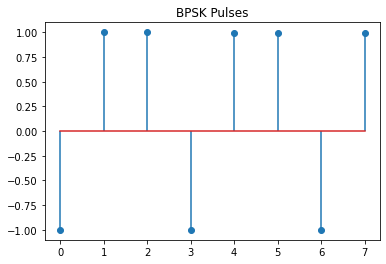

In [3]:
symbols = generate_bpsk(2048)
plt.stem(symbols.real[:8], use_line_collection=True)
plt.title('BPSK Pulses')
plt.show()

While this may seem a straightforward way to transfer bits around, looking at the frequency domain of these pulses we can see that they contain all frequencies. This is undesirable, because it would cause interference to other channels.

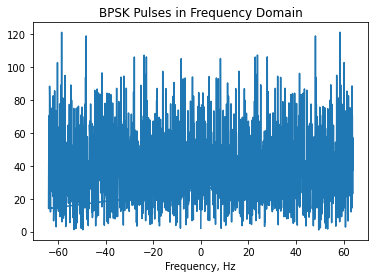

In [4]:
fs = 128
fft_size = 2048

y_fft = np.fft.fftshift(np.fft.fft(generate_bpsk(fft_size),fft_size))
freqs = np.fft.fftfreq(fft_size,1/fs)

plt.plot(freqs, np.abs(y_fft))
plt.xlabel('Frequency, Hz')
plt.title('BPSK Pulses in Frequency Domain')
plt.show()

## Square Pulse Shaping

One of the most simple forms of pulse shaping is the square pulse shape, where we repeat the same pulse N times per symbol - usually we refer to N as samples per symbol, or sps.

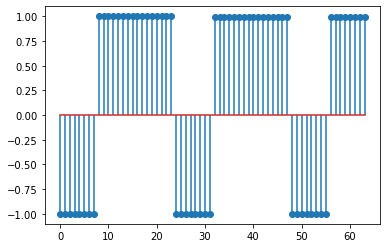

In [5]:
symbols_square_shaped = np.repeat(symbols,8)
plt.stem(symbols_square_shaped.real[:64], use_line_collection=True)
plt.show()

While this is better than transmitting pulses, square shapes still produce a lot of spectral emissions due to the sharp transitions in the time domain. If we take a clean square wave as an example, we can see that it is made of a combination of many harmonics in the frequency domain.

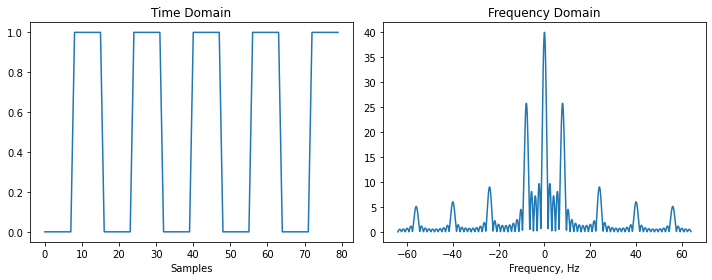

In [6]:
# Create clean square wave
square_wave = np.repeat(np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1]),8)

# Take the fft of the square wave and calculate corresponding x-axis frequencies
y_fft = np.fft.fftshift(np.fft.fft(square_wave,fft_size))
freqs = np.fft.fftshift(np.fft.fftfreq(fft_size,1/fs))

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(square_wave)
ax[0].set_xlabel('Samples')
ax[0].set_title('Time Domain')
ax[1].plot(freqs, np.abs(y_fft))
ax[1].set_xlabel('Frequency, Hz')
ax[1].set_title('Frequency Domain')
fig.tight_layout()

In a similar fashion taking the fft of our square pulse shaped waveform, we will see many side lobes interfering with nearby frequencies.

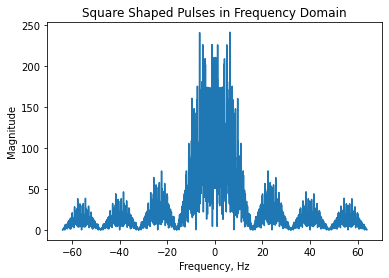

In [7]:
y_fft = np.fft.fftshift(np.fft.fft(symbols_square_shaped,fft_size))
freqs = np.fft.fftshift(np.fft.fftfreq(fft_size,1/fs))

plt.plot(freqs, np.abs(y_fft))
plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude')
plt.title('Square Shaped Pulses in Frequency Domain')
plt.show()

**Averaging at the receiver**

A square pulse shape receiver can take the shape as a moving average filter. We choose 4 weights here and set them to [0.25, 0.25, 0.25, 0.25], as we are oversampling with $N=4$ samples per symbol. We anticipate the filter to output a peak response of 1 once the filter fully overlaps with an incoming square pulse shape of 4 samples.

In [8]:
weights = [0.25, 0.25, 0.25, 0.25]
filtered_symbols = np.convolve(np.repeat(symbols,4).real, weights)

Convolving this filter across our pulse shaped signal will create triangular peaks or 'maximum effect points' that will minimise the chance of incorrect symbol decisions (under noisy conditions).

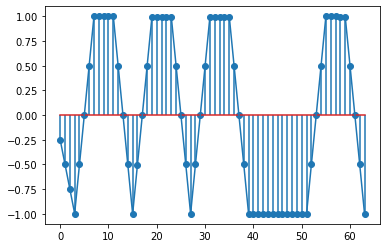

In [9]:
plt.stem(filtered_symbols.real[:64], use_line_collection=True)
plt.plot(filtered_symbols.real[:64])
plt.show()

While the receiver structure is clear, and the spectral properties are better than transmitting pulses and taking up all the bandwidth. Square pulse shapes are still introducing a lot of interference to nearby frequencies. Surely we can do better!

## Sinc Pulse Shape

The ideal bandlimiting response for transmitting our signal would be a “brick wall” — i.e. perfectly passing frequencies up to the actual signal bandwidth, with zero emissions on adjacent frequencies. However this is not realistically realisable, as we would need an infinitely expensive filter with weights seeing no end!

To create a more realistic pulse shaping filter we can use the Sinc pulse shape. Much like windowing functions, it has outputs that taper off at the ends and smooth out the response in order to reduce the sharp transitions that cause unwanted frequency emissions.

The sinc function is given by

$n(t) = \frac{sin(\pi t / T)}{\pi t / T}$

In Numpy we can simply call np.sinc

Lets visualize a Sinc shape filter that is 40 symbol periods long, that uses 5 samples per symbol. To realize this filter we will need 251 weights (40 symbols $\times$ 5 samples per symbol + 1 center weight = 251). We assume sample period of T=1s (sampling rate of 1Hz) - in the next cells we will omit T because it is just 1. Just keep in mind that it is part of the formula.

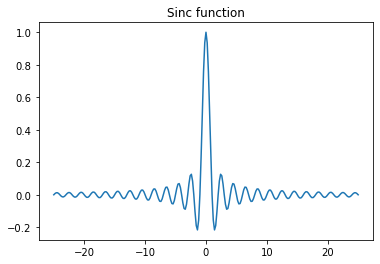

In [10]:
T = 1 # sample period
sps = 5 # symbol period in samples
num_weights = 251
x = np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/sps/T
sinc_weights = np.sinc(x)

plt.plot(x,sinc_weights)
plt.title('Sinc function')
plt.show()

Before checking it out in the frequency domain let's generate another filter that runs for only 4 symbol periods to compare the frequency responses.

In [11]:
# Create another, shorter sinc filter
# num_weights = 4 symbol periods * 5 samples per symbol + 1
num_weights = 21
x = np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/sps
sinc_weights2 = np.sinc(x)

Visualizing the filter responses in the frequency domain we can see that the more symbol samples the filter is allowed, the closer we get to the ideal cut-off, where desired frequencies of the main lobe are passed, while any unnecessary emissions are minimized. This relationship basically tells that more filter weights in time domain -> better spectral properties in frequency domain.

Text(0.5, 1.0, 'Sinc filter magnitude responses')

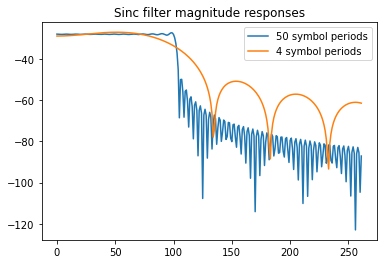

In [12]:
# Calculate frequency responses of the 2 filters
fft_size = 1024
sinc1_response = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(sinc_weights, fft_size)))/fs)
sinc2_response = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(sinc_weights2, fft_size)))/fs)

# Plot the frequency responses
plt.plot(sinc1_response[int(fft_size/2):-250]) # truncated for better viewing experience
plt.plot(sinc2_response[int(fft_size/2):-250])

plt.legend(('50 symbol periods', '4 symbol periods'))
plt.title('Sinc filter magnitude responses')

What if we are limited in the number of filter weights we want to use (which we often are), but still want to minimze the outer frequency emissions? Well we can build on our sinc filter.

## Raised Cosine

The Raised Cosine (RC) pulse shape has a preferable impulse response that
tails off more quickly (as governed by the design parameter α ). Defined as 

$p(t) = (\frac{sin(\pi t / T)}{\pi t / T}) (\frac{cos \alpha \pi t / T}{1 - (2\alpha t / T)^{2}})$

Note that if $\alpha = 0$, the second part of the equation becomes equal to 1, and we end up with a response equivalent to the sinc function.

Here we can visualize what effect the paramter $\alpha$ has on our new Raised Cosine filter response. We can see that the cosine window term suppresses the tails of the Sinc shape as the $\alpha$ term increases - this allows us to get away with designing a cheaper pulse shaping filter.

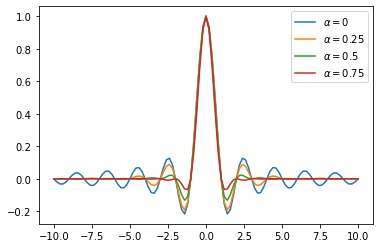

In [13]:
sps = 5
num_weights = 101
x = 0.9999*np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/sps

alphas = [0, 0.25, 0.5, 0.75]
for alpha in alphas:
    raised_cos_weights = np.sinc(x)*(np.cos(alpha*np.pi*x)/(1-((2*alpha*x)**2)))
    plt.plot(x,raised_cos_weights)

plt.legend((r'$\alpha = 0$', r'$\alpha = 0.25$', r'$\alpha = 0.5$', r'$\alpha = 0.75$'))

Once we look at the filter responses at different $\alpha$ values, we can see that the required bandwidth to capture our signal increases with $\alpha$ - which is where its other name, excess bandwidth, comes from. Like most things, the $\alpha$ paramter is a tradeoff, between how much spectral leakage you are allowing to nearby frequencies and how much bandwidth will be required to recover the transmitted signal.

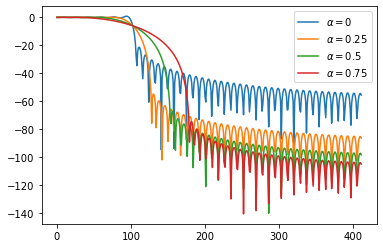

In [14]:
sps = 5
num_weights = 121
x = 0.9999*np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/sps

for alpha in alphas:
    raised_cos_weights = np.sinc(x)*(np.cos(alpha*np.pi*x)/(1-((2*alpha*x)**2)))

    rcos_response = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(raised_cos_weights, fft_size)))/sps)
    plt.plot(rcos_response[int(fft_size/2):-100])
    
plt.legend((r'$\alpha = 0$', r'$\alpha = 0.25$', r'$\alpha = 0.5$', r'$\alpha = 0.75$'))

**Raised Cosine Pulse Shaping**

We will use a simple 8 symbol period, or 41 weight RC filter.

In [15]:
fs = 5
num_weights = 41
alpha = 0.5
x = 0.9999*np.arange(-int(num_weights/2),int(num_weights/2),1)/fs
raised_cos_weights = np.sinc(x)*(np.cos(alpha*np.pi*x)/(1-((2*alpha*x)**2)))

Here we generate 3 pulses, each 5 samples or 1 symbol period apart, so they do not interfere with each other. Notice how pulse shaping causes a delay in the signal - our first peak is no longer at index 5, but 25! This is because pulse shaping introduces latency, and for our RC filter this is half the total pulse duration, which is 4 symbol periods (or 20 samples).

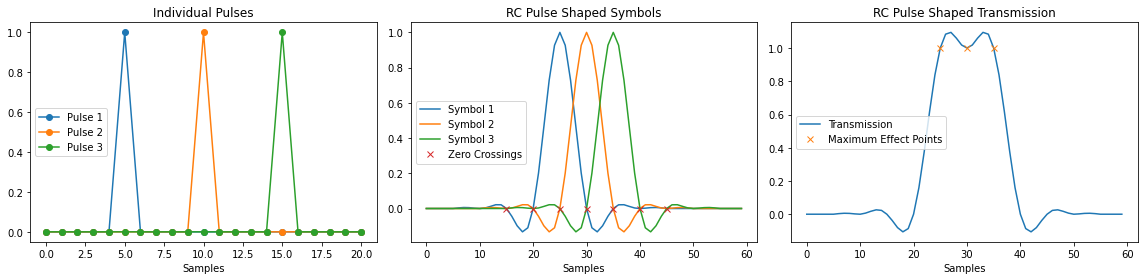

In [16]:
# Generate pulse vectors
pulse1 = np.zeros(21,)
pulse2 = np.zeros(21,)
pulse3 = np.zeros(21,)
pulse1[5] = 1
pulse2[10] = 1
pulse3[15] = 1

# Pulse shape each symbol separately 
symbol1_rc = np.convolve(pulse1,raised_cos_weights).real
symbol2_rc = np.convolve(pulse2,raised_cos_weights).real
symbol3_rc = np.convolve(pulse3,raised_cos_weights).real

# Pulse shape the combination of symbols
symbols_rc = np.convolve(pulse1+pulse2+pulse3,raised_cos_weights).real

# Plot them all
fig, ax = plt.subplots(1,3, figsize=(16,4))

ax[0].plot(pulse1, '-o')
ax[0].plot(pulse2, '-o')
ax[0].plot(pulse3, '-o')
ax[0].set_title('Individual Pulses')
ax[0].set_xlabel('Samples')
ax[0].legend(('Pulse 1', 'Pulse 2', 'Pulse 3'), loc='center left')

ax[1].plot(symbol1_rc)
ax[1].plot(symbol2_rc)
ax[1].plot(symbol3_rc)
ax[1].plot([15,20,25,30,35,40,45], [0,0,0,0,0,0,0], 'x')
ax[1].set_title('RC Pulse Shaped Symbols')
ax[1].set_xlabel('Samples')
ax[1].legend(('Symbol 1', 'Symbol 2', 'Symbol 3', 'Zero Crossings'), loc='center left')

ax[2].plot(symbols_rc)
ax[2].plot([5+20,10+20,15+20], [1,1,1],'x')
ax[2].set_title('RC Pulse Shaped Transmission')
ax[2].set_xlabel('Samples')
ax[2].legend(('Transmission', 'Maximum Effect Points'), loc='center left')
fig.tight_layout()

Great thing about the RC filter is that it does not introduce Inter Symbol Interference (ISI) - that is the maximum effect points are unaffected by the neighbouring symbols. While they do overlap with each other, their amplitude is exactly 0 at the peaks of other symbols.

## Matched Filtering with Root Raised Cosine



In [17]:
# np.sinc(x)*(np.cos(alpha*np.pi*x)/(1-((2*alpha*x)**2)))
# h_rrc = (np.sin(np.pi*t*(1-alpha)/Ts) +  \
#                     4*alpha*(t/Ts)*np.cos(np.pi*t*(1+alpha)/Ts))/ \
#                     (np.pi*t*(1-(4*alpha*t/Ts)*(4*alpha*t/Ts))/Ts)